<a href="https://colab.research.google.com/github/robjmenna/RBE595_deeplearning_final/blob/main/resnet151.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

In [3]:

test = tfds.load('imagenette', split='validation')

Shuffling and writing examples to C:\/Users/robjm/tensorflow_datasets/imagenette/full-size-v2/0.1.0.incompleteUNK3O6/imagenette-train.tfrecord


Shuffling and writing examples to C:\/Users/robjm/tensorflow_datasets/imagenette/full-size-v2/0.1.0.incompleteUNK3O6/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to C:\Users\robjm\tensorflow_datasets\imagenette\full-size-v2\0.1.0. Subsequent calls will reuse this data.


label: 9


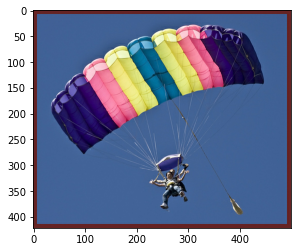

In [5]:
import matplotlib.pyplot as plt
import utils

labels = utils.imagenetlabels()
ds = test.map(lambda x: (x['image'], x['label']))

ex = next(ds.take(1).as_numpy_iterator())
plt.imshow(ex[0])
print('label: ' + str(ex[1]))
ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y,1001))).batch(1)

In [10]:
# %%timeit

import tensorflow_hub as hub

m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4")
])
m.build([None, 224, 224, 3])  # Batch input shape.

10.6 s ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# %%timeit

sample = ds.skip(3).take(1)
img, scores = next(sample.as_numpy_iterator())

scores = m.predict(sample, verbose=1)
plt.imshow(img[0,:,:,:])

print('score: ' + str(np.max(scores)))
i = np.argmax(scores)
print('label: ' + labels[i])

NameError: name 'm' is not defined